In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from typing import List, Tuple
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim import Adam
from tqdm import tqdm
import pandas as pd

In [2]:

class DataPreprocessor:
    def __init__(self, location_mask, measurement_mask, dataset, downsample_factor=30):
        """
        Args:
            location_mask (np.ndarray): (H, W, 2) coordinates.
            measurement_mask (np.ndarray): (H, W) or (H, W, 1), indicating measurement locations.
            dataset (np.ndarray): (N, H, W), N = number of samples.
            downsample_factor (int): Number of samples to average together.
        """
        self.location_mask = location_mask
        self.measurement_mask = measurement_mask
        self.dataset = dataset
        self.downsample_factor = downsample_factor

    def downsample(self):
        """Downsample by averaging over 'downsample_factor' samples."""
        n_samples = self.dataset.shape[0]
        n_groups = n_samples // self.downsample_factor  # ✅ define this
        ds_data = []

        for i in range(n_groups):
            start = i * self.downsample_factor
            end = start + self.downsample_factor
            avg_sample = np.mean(self.dataset[start:end], axis=0)
            ds_data.append(avg_sample)

        return np.stack(ds_data)
    
    def get_prepared_data(self):
        X = self.downsample()
        return X


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple

class ConditionalVAE(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 loc_channels: int = 2,
                 mask_channels: int = 1,
                 latent_dim: int = 16,
                 hidden_dims: List[int] = [32, 64, 128, 256, 512],
                 img_size: int = 40):
        super().__init__()

        self.latent_dim = latent_dim
        self.img_size = img_size
        self.in_channels = in_channels
        self.loc_channels = loc_channels
        self.mask_channels = mask_channels

        # ---------------- Encoder ----------------
        enc_in_channels = in_channels + loc_channels + mask_channels
        self.hidden_dims_enc = hidden_dims
        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(enc_in_channels, h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            enc_in_channels = h_dim
        self.encoder = nn.Sequential(*modules)

        # Compute encoder output sizes dynamically
        encoder_sizes = self.compute_encoder_sizes(img_size, hidden_dims)
        self.final_spatial = encoder_sizes[-1]
        flat_size = hidden_dims[-1] * self.final_spatial**2

        # Latent space
        self.fc_mu = nn.Linear(flat_size, latent_dim)
        self.fc_var = nn.Linear(flat_size, latent_dim)

        # ---------------- Decoder ----------------
        self.decoder_input = nn.Linear(
            latent_dim + (loc_channels + mask_channels) * img_size * img_size,
            flat_size
        )

        self.hidden_dims_dec = hidden_dims[::-1]

        dec_modules = []
        for i in range(len(self.hidden_dims_dec) - 1):
            dec_modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        self.hidden_dims_dec[i],
                        self.hidden_dims_dec[i+1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=0  # always 0, we will pad later
                    ),
                    nn.BatchNorm2d(self.hidden_dims_dec[i+1]),
                    nn.LeakyReLU()
                )
            )
        self.decoder = nn.Sequential(*dec_modules)

        self.final_mu = nn.Conv2d(self.hidden_dims_dec[-1], out_channels=in_channels, kernel_size=3, padding=1)
        self.final_logvar = nn.Conv2d(self.hidden_dims_dec[-1], out_channels=in_channels, kernel_size=3, padding=1)

    # ---------------- Static methods ----------------
    @staticmethod
    def compute_encoder_sizes(img_size, hidden_dims, kernel_size=3, stride=2, padding=1):
        sizes = []
        size = img_size
        for _ in hidden_dims:
            size = (size + 2*padding - kernel_size) // stride + 1
            sizes.append(size)
        return sizes

    # ---------------- Forward methods ----------------
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var

    def reparameterize(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z: torch.Tensor, loc_mask: torch.Tensor, meas_mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Combine conditioning info
        cond = torch.cat([loc_mask, meas_mask], dim=1)
        cond_flat = cond.view(cond.size(0), -1)
        dec_input = torch.cat([z, cond_flat], dim=1)

        result = self.decoder_input(dec_input)
        result = result.view(-1, self.hidden_dims_dec[0], self.final_spatial, self.final_spatial)
        result = self.decoder(result)

        # Zero-pad to ensure output is img_size x img_size
        _, _, h, w = result.shape
        pad_h = self.img_size - h
        pad_w = self.img_size - w
        if pad_h > 0 or pad_w > 0:
            # pad = (left, right, top, bottom)
            result = F.pad(result, (0, pad_w, 0, pad_h))

        mu_pred = self.final_mu(result)
        logvar_pred = torch.clamp(self.final_logvar(result), -10, 10)
        return mu_pred, logvar_pred

    def forward(self, x: torch.Tensor, loc_mask: torch.Tensor, meas_mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        # Tile location mask if needed
        if loc_mask.dim() == 3:
            loc_mask = loc_mask.unsqueeze(0).repeat(x.size(0), 1, 1, 1)

        enc_in = torch.cat([x, loc_mask, meas_mask], dim=1)
        mu, log_var = self.encode(enc_in)
        z = self.reparameterize(mu, log_var)
        mu_pred, logvar_pred = self.decode(z, loc_mask, meas_mask)
        return mu_pred, logvar_pred, mu, log_var

    # ---------------- Loss function ----------------
    def loss_function(self, x: torch.Tensor, mu_pred: torch.Tensor, logvar_pred: torch.Tensor,
                      mu: torch.Tensor, log_var: torch.Tensor, kld_weight: float = 1e-3) -> dict:
        const = torch.log(torch.tensor(2.0 * torch.pi, device=x.device))
        recon_var = torch.exp(logvar_pred)
        nll_element = 0.5 * ((x - mu_pred)**2 / recon_var + logvar_pred + const)
        nll_loss = torch.mean(torch.sum(nll_element, dim=[1,2,3]))

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        total_loss = nll_loss + kld_weight * kld_loss
        return {"loss": total_loss, "NLL": nll_loss, "KLD": kld_loss}


In [4]:
""" N, H, W = 1500, 40, 40
location_mask = np.random.rand(H, W, 2)
measurement_mask = np.random.randint(0, 2, (H, W))
dataset = np.random.rand(N, H, W)

prep = DataPreprocessor(location_mask, measurement_mask, dataset, downsample_factor=30)
X = prep.get_prepared_data()  # shape (N//30, H, W)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)         # (batch, 1, H, W)
loc_mask = torch.tensor(location_mask, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # (1, 2, H, W)
meas_mask = torch.tensor(measurement_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)

# Repeat masks for all samples in batch
loc_mask = loc_mask.repeat(X.size(0), 1, 1, 1)
meas_mask = meas_mask.repeat(X.size(0), 1, 1, 1)

# Create Dataset + DataLoader
dataset = TensorDataset(X, loc_mask, meas_mask)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

# ===============================================================
# 2️⃣ Initialize model + optimizer
# ===============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dims=[32, 64, 128, 256, 512]

model = ConditionalVAE(
    in_channels=1,
    loc_channels=2,
    mask_channels=1,
    latent_dim=16,
    img_size=H,
    hidden_dims=hidden_dims,
).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
epochs = 50
kld_weight = 1e-3  # you can anneal this if needed

# ===============================================================
# 3️⃣ Training loop
# ===============================================================
for epoch in range(epochs):
    model.train()
    train_loss, val_loss = 0.0, 0.0

    for x_batch, loc_batch, mask_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        x_batch = x_batch.to(device)
        loc_batch = loc_batch.to(device)
        mask_batch = mask_batch.to(device)

        optimizer.zero_grad()
        mu_pred, logvar_pred, mu, log_var = model(x_batch,loc_batch, mask_batch)
        losses = model.loss_function(x_batch, mu_pred, logvar_pred, mu, log_var, kld_weight)
        loss = losses["loss"]

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_batch.size(0)

    # Validation loop
    model.eval()
    with torch.no_grad():
        for x_batch, loc_batch, mask_batch in val_loader:
            x_batch = x_batch.to(device)
            loc_batch = loc_batch.to(device)
            mask_batch = mask_batch.to(device)
            mu_pred, logvar_pred, mu, log_var = model(x_batch, loc_batch, mask_batch)
            losses = model.loss_function(x_batch, mu_pred, logvar_pred, mu, log_var, kld_weight)
            val_loss += losses["loss"].item() * x_batch.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# ===============================================================
# 4️⃣ Save model
# ===============================================================
torch.save(model.state_dict(), "sivae_sinr.pt")
print("✅ Training complete! Model saved.") """

' N, H, W = 1500, 40, 40\nlocation_mask = np.random.rand(H, W, 2)\nmeasurement_mask = np.random.randint(0, 2, (H, W))\ndataset = np.random.rand(N, H, W)\n\nprep = DataPreprocessor(location_mask, measurement_mask, dataset, downsample_factor=30)\nX = prep.get_prepared_data()  # shape (N//30, H, W)\n\n# Convert to torch tensors\nX = torch.tensor(X, dtype=torch.float32).unsqueeze(1)         # (batch, 1, H, W)\nloc_mask = torch.tensor(location_mask, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # (1, 2, H, W)\nmeas_mask = torch.tensor(measurement_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)\n\n# Repeat masks for all samples in batch\nloc_mask = loc_mask.repeat(X.size(0), 1, 1, 1)\nmeas_mask = meas_mask.repeat(X.size(0), 1, 1, 1)\n\n# Create Dataset + DataLoader\ndataset = TensorDataset(X, loc_mask, meas_mask)\ntrain_size = int(0.8 * len(dataset))\nval_size = len(dataset) - train_size\ntrain_data, val_data = random_split(dataset, [train_size, val_size])\n\ntrain

In [5]:


import pandas as pd
import numpy as np
import torch

# --- Define constants ---
H, W = 40, 40

# --- Load SINR data FIRST to determine N ---
print("Loading measured_points_with_sinr.csv to determine N...")
df_dataset = pd.read_csv('sinr_output.csv') # This has 1600 rows

# Get all SINR column names
sinr_cols = [col for col in df_dataset.columns if col.startswith('SINR_')]
N = len(sinr_cols)
print(f"Determined N = {N} samples from SINR columns.")


# --- 1. Load LOCATION MASK (Your grid_coordinates.csv) ---
df_grid = pd.read_csv('original_1600_grid_points.csv') # Assuming this is your 1600-row file

# Get the Y and X values (Y first for (row, col))
y_values = df_grid['y'].to_numpy()
x_values = df_grid['x'].to_numpy()

# Stack them (1600, 2) and reshape (40, 40, 2)
location_values = np.stack([y_values, x_values], axis=-1)
location_mask = location_values.reshape(H, W, 2) # This is your PERFECT Line 1

print(f"Loaded location_mask, shape: {location_mask.shape}") # (40, 40, 2)

# --- NEW: Create (Y, X) pixel indices for all 1600 grid points ---
# We assume the 1600 points are stored in row-major order
# (0,0), (0,1), ..., (0,39), (1,0), ...
all_y_pixel_indices = np.arange(H * W) // W  # Integer division -> [0,0,...,0, 1,1,...,1, ...]
all_x_pixel_indices = np.arange(H * W) % W   # Modulo -> [0,1,...,39, 0,1,...,39, ...]

# --- 2. Load SENSOR LIST (Your Mask_points_with_measured_flag.csv) ---

# Load the full file
df_mask = pd.read_csv('mask.csv')

# Y_INDEX_COL = 'y' # <-- We don't need these columns from mask.csv
# X_INDEX_COL = 'x' # <-- We don't need these columns from mask.csv
FLAG_COL = 'mask'  

# --- NEW: Create a boolean mask from all 1600 rows ---
# This assumes 'mask.csv' has all 1600 grid points in order
boolean_sensor_mask = (df_mask[FLAG_COL] == 1).to_numpy() # Shape (1600,)
print(f"Created boolean mask with {boolean_sensor_mask.sum()} sensors.")

# --- DELETED: This block is replaced ---
# sensor_df = df_mask[boolean_sensor_mask] # Use the boolean mask for consistency
# y_indices = sensor_df[Y_INDEX_COL].to_numpy(dtype = int)
# x_indices = sensor_df[X_INDEX_COL].to_numpy(dtype= int)
# --- END DELETED BLOCK ---

# --- REPLACEMENT: Get pixel indices for sensors ---
# Use the boolean mask to filter our generated (y, x) pixel indices
y_indices = all_y_pixel_indices[boolean_sensor_mask]
x_indices = all_x_pixel_indices[boolean_sensor_mask]

# Check if we got the right number of sensors
num_train_locs = len(y_indices)
if num_train_locs != boolean_sensor_mask.sum():
    print(f"Warning: Mismatch in sensor count. {num_train_locs} vs {boolean_sensor_mask.sum()}")

# 3. Create the (Y, X) tensors for the training loop
train_coords_y = torch.tensor(y_indices, dtype=torch.long)
train_coords_x = torch.tensor(x_indices, dtype=torch.long)
# num_train_locs = len(train_coords_y) # <-- Moved up


print(f"Extracted {num_train_locs} sensor locations for training.")
# 4. Select specific validation points using provided indices
print("\n--- Creating Validation Set from Specific Indices ---")

# The user-provided indices (from the 30 available sensors)
my_val_indices = [3, 6, 25, 12, 13, 17, 19, 21, 10, 2]

# Select the (y, x) pixel coordinates from the training tensors
val_coords_y = train_coords_y[my_val_indices]
val_coords_x = train_coords_x[my_val_indices]

print(f"Created specific validation set with {len(val_coords_y)} locations from indices.")
print(f"Validation Y indices: {val_coords_y}")
print(f"Validation X indices: {val_coords_x}")
print("----------------------------------------------------------\n")

# --- Data is already loaded, just filter it ---
# print("Loading measured_points_with_sinr.csv...") # <-- Already done
# df_dataset = pd.read_csv('sinr_output.csv') # <-- Already done

# --- NEW: Filter df_dataset to ONLY include the 30 sensor rows ---
sensor_sinr_df = df_dataset[boolean_sensor_mask]
print(f"Filtered SINR data to {sensor_sinr_df.shape[0]} sensor rows.")

# Get all SINR column names
# sinr_cols = [col for col in df_dataset.columns if col.startswith('SINR_')] # <-- Already done
# if len(sinr_cols) != N: # <-- This check is now redundant
#     print(f"Warning: N is {N} but found {len(sinr_cols)} SINR columns.")

# Get the SINR data, shape (30, N)
# --- CHANGED: Use sensor_sinr_df, NOT df_dataset ---
sinr_data = sensor_sinr_df[sinr_cols].to_numpy()

# Transpose to (N_samples, N_sensors), shape (N, 30)
sinr_data_transposed = sinr_data.T
print(f"Loaded SINR data, shape {sinr_data_transposed.shape}") # Should be (N, 30)

# --- 4. Build the (N, H, W) dataset ---
# Create an empty (N, 40, 40) array
dataset_images = np.zeros((N, H, W), dtype=np.float32)

# --- This loop is now correct ---
for i in range(N):
    # Get the 30 sensor values for this sample. Shape is (30,)
    sample_values = sinr_data_transposed[i]
    
    # Place each sensor value at its (y, x) pixel location
    # Destination shape (30,) = Source shape (30,)
    dataset_images[i, y_indices, x_indices] = sample_values

print(f"Built (N, H, W) dataset, shape: {dataset_images.shape}")
measurement_mask_dummy = np.zeros((H, W))
# 7. Run the DataPreprocessor
prep = DataPreprocessor(
    location_mask=location_mask,               # The REAL (40, 40, 2) grid
    measurement_mask=measurement_mask_dummy,   # The DUMMY (40, 40) array
    dataset=dataset_images,
    downsample_factor=10
)
X = prep.get_prepared_data()  # shape (N//30, H, W)

# 8. Convert data to Tensors
X_data = torch.tensor(X, dtype=torch.float32).unsqueeze(1) # (batch, 1, H, W)
loc_mask_base = torch.tensor(location_mask, dtype=torch.float32).permute(2, 0, 1) # (2, H, W)


Loading measured_points_with_sinr.csv to determine N...
Determined N = 9856 samples from SINR columns.
Loaded location_mask, shape: (40, 40, 2)
Created boolean mask with 30 sensors.
Extracted 30 sensor locations for training.

--- Creating Validation Set from Specific Indices ---
Created specific validation set with 10 locations from indices.
Validation Y indices: tensor([ 6,  9, 31, 15, 16, 20, 23, 26, 14,  5])
Validation X indices: tensor([12, 13, 12, 19, 11, 21, 21, 24, 10,  8])
----------------------------------------------------------

Filtered SINR data to 30 sensor rows.
Loaded SINR data, shape (9856, 30)
Built (N, H, W) dataset, shape: (9856, 40, 40)


In [6]:
random_sensor_indices = np.random.choice(num_train_locs, 2, replace=False)

# Get the first random sensor's details
sensor_index_1 = random_sensor_indices[0]
y1, x1 = y_indices[sensor_index_1], x_indices[sensor_index_1]
# Get the first 10 values for this sensor
values_1 = dataset_images[:10, y1, x1]

print(f"Random Sensor 1 at (y={y1}, x={x1}):")
print(values_1)

# Get the second random sensor's details
sensor_index_2 = random_sensor_indices[1]
y2, x2 = y_indices[sensor_index_2], x_indices[sensor_index_2]
# Get the first 10 values for this sensor
values_2 = dataset_images[:10, y2, x2]


print(f"\nRandom Sensor 2 at (y={y2}, x={x2}):")
print(values_2)
print("-------------------------------------\n")

Random Sensor 1 at (y=17, x=30):
[-2.7301097 -2.7301097 -2.7301097 -2.7301097 -2.7301097 -2.7301097
 -2.7301097 -2.7301097 -2.7301097 -2.7301097]

Random Sensor 2 at (y=30, x=23):
[-3.2434385 -3.2434385 -3.2434385 -3.2434385 -3.2434385 -3.2434385
 -3.2434385 -3.2434385 -3.2434385 -3.2434385]
-------------------------------------



In [7]:
# --- The rest of the code (DataLoaders, Model, Training Loop) follows... ---


""" my_train_coords = [
    (918, 562), (891, 725), (838, 534), (731, 344), (705, 670),
    (705, 372), (625, 589), (572, 317), (492, 725), (492, 779),
    (466, 833), (439, 317), (412, 534), (412, 426), (386, 290),
    (359, 670), (333, 426), (306, 589), (253, 263), (146, 236),
    (120, 534), (731, 507), (918, 426), (173, 344), (545, 589),
    (226, 507), (120, 426), (811, 643), (838, 344), (253, 372)
] """

num_train_locs = len(train_coords_y) # This must be 21
num_train_locs = len(train_coords_y) # 21

# 2. Define k-sampling parameters
k_choices = torch.tensor([5, 10, 15, 18])
k_probs = torch.tensor([0.133, 0.6, 0.133, 0.133])

# --- MODIFICATION END ---

# Create Dataset (ONLY with X, the ground truth)
# The loc_mask and meas_mask will be generated on-the-fly
dataset = TensorDataset(X_data) 
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

# ===============================================================
# 2️⃣ Initialize model + optimizer
# ===============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dims=[32, 64, 128, 256, 512]

model = ConditionalVAE(
    in_channels=1,
    loc_channels=2,
    mask_channels=1,
    latent_dim=16,
    img_size=H,
    hidden_dims=hidden_dims,
).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
epochs = 50
kld_weight = 1e-3

# --- MODIFICATION: Move base tensors to device ---
loc_mask_base = loc_mask_base.to(device)
train_coords_y = train_coords_y.to(device)
train_coords_x = train_coords_x.to(device)
val_coords_y = val_coords_y.to(device)
val_coords_x = val_coords_x.to(device)
k_choices = k_choices.to(device)
k_probs = k_probs.to(device)
# ---

# ===============================================================
# 3️⃣ Training loop
# ===============================================================
for epoch in range(epochs):
    model.train()
    train_loss, val_loss = 0.0, 0.0

    # --- MODIFICATION: Loader only yields x_batch ---
    for (x_batch,) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        x_batch = x_batch.to(device) # This is the ground truth
        batch_size = x_batch.size(0)

        # 1. Create location mask batch (repeat the base grid)
        loc_batch = loc_mask_base.unsqueeze(0).repeat(batch_size, 1, 1, 1)
        
        # 2. Create dynamic measurement mask batch
        # Sample k for each item in the batch
        k_samples_indices = torch.multinomial(k_probs, num_samples=batch_size, replacement=True)
        k_values = k_choices[k_samples_indices]
        
        # Create masks one by one (since k varies)
        mask_batch = torch.zeros(batch_size, 1, H, W, device=device)
        for i in range(batch_size):
            k = k_values[i].item()
            # Randomly pick k indices from the 21 available
            indices_to_pick = torch.randperm(num_train_locs, device=device)[:k]
            # Get the y, x coordinates for these k points
            y = train_coords_y[indices_to_pick]
            x = train_coords_x[indices_to_pick]
            # Set the mask
            mask_batch[i, 0, y, x] = 1.0
        
        # 3. Create masked input
        x_input_batch = x_batch * mask_batch # Encoder sees only observed values

        optimizer.zero_grad()
        
        # Model takes masked input, but loss compares to ground truth
        mu_pred, logvar_pred, mu, log_var = model(x_input_batch, loc_batch, mask_batch)
        losses = model.loss_function(x_batch, mu_pred, logvar_pred, mu, log_var, kld_weight) # Loss uses original x_batch
        loss = losses["loss"]

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_batch.size(0)

    # Validation loop
    model.eval()
    
    # --- MODIFICATION: Create the *fixed* 9-point validation mask *once* ---
    val_mask_base = torch.zeros(1, 1, H, W, device=device)
    val_mask_base[0, 0, val_coords_y, val_coords_x] = 1.0
    
    with torch.no_grad():
        # --- MODIFICATION: Loader only yields x_batch ---
        for (x_batch,) in val_loader: 
            x_batch = x_batch.to(device)
            batch_size = x_batch.size(0)
            
            # 1. Create loc_batch
            loc_batch = loc_mask_base.unsqueeze(0).repeat(batch_size, 1, 1, 1)
            
            # 2. Create mask_batch (repeat the fixed val mask)
            mask_batch = val_mask_base.repeat(batch_size, 1, 1, 1)
            
            # 3. Create masked input
            x_input_batch = x_batch * mask_batch
            
            mu_pred, logvar_pred, mu, log_var = model(x_input_batch, loc_batch, mask_batch)
            losses = model.loss_function(x_batch, mu_pred, logvar_pred, mu, log_var, kld_weight)
            val_loss += losses["loss"].item() * x_batch.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# ===============================================================
# 4️⃣ Save model
# ===============================================================
#torch.save(model.state_dict(), "sivae_sinr.pt")
print("✅ Training complete! Model saved.")

Epoch [1/50] | Train Loss: 863.2561 | Val Loss: 700.3702


Epoch [2/50] | Train Loss: 581.4732 | Val Loss: 967.5461


Epoch [3/50] | Train Loss: 442.8174 | Val Loss: 282.0546


Epoch [4/50] | Train Loss: 422.3885 | Val Loss: 215.4093


Epoch [5/50] | Train Loss: 137.2298 | Val Loss: -91.4068


Epoch [6/50] | Train Loss: -258.3603 | Val Loss: -322.4479


Epoch [7/50] | Train Loss: -351.4411 | Val Loss: -430.3171


Epoch [8/50] | Train Loss: -442.9932 | Val Loss: -490.7836


Epoch [9/50] | Train Loss: -504.9549 | Val Loss: -575.5269


Epoch [10/50] | Train Loss: -572.8909 | Val Loss: -556.8971


Epoch [11/50] | Train Loss: -634.9004 | Val Loss: -698.8354


Epoch [12/50] | Train Loss: -721.4348 | Val Loss: -761.6551


Epoch [13/50] | Train Loss: -738.3450 | Val Loss: -819.8559


Epoch [14/50] | Train Loss: -831.0287 | Val Loss: -777.4483


Epoch [15/50] | Train Loss: -863.7257 | Val Loss: -928.8993


Epoch [16/50] | Train Loss: -925.1452 | Val Loss: -962.8116


Epoch [17/50] | Train Loss: -1021.3646 | Val Loss: -1046.6868


Epoch [18/50] | Train Loss: -1044.1811 | Val Loss: -1109.1384


Epoch [19/50] | Train Loss: -1102.3771 | Val Loss: -1165.5769


Epoch [20/50] | Train Loss: -1153.0405 | Val Loss: -1192.9329


Epoch [21/50] | Train Loss: -1238.5904 | Val Loss: -1276.1282


Epoch [22/50] | Train Loss: -1278.7503 | Val Loss: -1330.3906


Epoch [23/50] | Train Loss: -1333.1271 | Val Loss: -1383.6618


Epoch [24/50] | Train Loss: -1378.0575 | Val Loss: -1436.6963


Epoch [25/50] | Train Loss: -1449.4536 | Val Loss: -1476.9177


Epoch [26/50] | Train Loss: -1495.0954 | Val Loss: -1540.6359


Epoch [27/50] | Train Loss: -1532.6154 | Val Loss: -1590.9719


Epoch [28/50] | Train Loss: -1575.1986 | Val Loss: -1628.4810


Epoch [29/50] | Train Loss: -1662.4768 | Val Loss: -1688.7252


Epoch [30/50] | Train Loss: -1687.0432 | Val Loss: -1735.5562


Epoch [31/50] | Train Loss: -1725.7427 | Val Loss: -1779.6529


Epoch [32/50] | Train Loss: -1796.2674 | Val Loss: -1822.5562


Epoch [33/50] | Train Loss: -1791.4496 | Val Loss: -1864.7870


Epoch [34/50] | Train Loss: -1886.1020 | Val Loss: -1905.9069


Epoch [35/50] | Train Loss: -1914.8465 | Val Loss: -1940.0252


Epoch [36/50] | Train Loss: -1930.3050 | Val Loss: -1980.1557


Epoch [37/50] | Train Loss: -1978.1902 | Val Loss: -1927.1013


Epoch [38/50] | Train Loss: -2023.3741 | Val Loss: -2046.5048


Epoch [39/50] | Train Loss: -2036.2277 | Val Loss: -2076.5242


Epoch [40/50] | Train Loss: -2075.7034 | Val Loss: -2097.3218


Epoch [41/50] | Train Loss: -2094.0034 | Val Loss: -2113.7168


Epoch [42/50] | Train Loss: -2140.1207 | Val Loss: -2149.4384


Epoch [43/50] | Train Loss: -2128.3743 | Val Loss: -2172.3441


Epoch [44/50] | Train Loss: -2171.4373 | Val Loss: -2131.5157


Epoch [45/50] | Train Loss: -2176.8662 | Val Loss: -2201.7747


Epoch [46/50] | Train Loss: -2210.6578 | Val Loss: -2203.5297


Epoch [47/50] | Train Loss: -2209.1916 | Val Loss: -2227.9709


Epoch [48/50] | Train Loss: -2214.9686 | Val Loss: -2230.5307


Epoch [49/50] | Train Loss: -2243.3484 | Val Loss: -2243.6738


Epoch [50/50] | Train Loss: -2218.5564 | Val Loss: -2254.3213
✅ Training complete! Model saved.


In [10]:
# ===============================================================
# 5️⃣ Performance Evaluation on one Sample
# ===============================================================
print("\n--- Evaluating performance on one validation sample ---")
model.eval()
with torch.no_grad():
    # Get one batch from the validation loader
    try:
        (x_batch,) = next(iter(val_loader))
    except StopIteration:
        print("Could not get a sample from val_loader, re-creating.")
        val_loader = DataLoader(val_data, batch_size=8, shuffle=False)
        (x_batch,) = next(iter(val_loader))

    # Take the first item as our sample
    x_sample_gt = x_batch[0].to(device).unsqueeze(0) # Shape: (1, 1, H, W). This is Ground Truth
    
    # 1. Re-create the fixed validation mask for 1 sample ("Seen" mask)
    seen_sensor_mask = torch.zeros(1, 1, H, W, device=device)
    seen_sensor_mask[0, 0, val_coords_y, val_coords_x] = 1.0
    
    # 2. Create the location grid for 1 sample
    loc_sample = loc_mask_base.unsqueeze(0) # Shape: (1, 2, H, W)
    
    # 3. Create the masked input
    x_input_sample = x_sample_gt * seen_sensor_mask
    
    # 4. Run the model to get the reconstruction (the mean prediction)
    mu_pred, _, _, _ = model(x_input_sample, loc_sample, seen_sensor_mask)
    # mu_pred is the reconstructed image, shape (1, 1, H, W)
    print("Generated one sample reconstruction.")

    # 5. Create the "unseen sensor" mask for a better metric
    # Mask for ALL 30 sensors
    full_sensor_mask = torch.zeros(1, 1, H, W, device=device)
    full_sensor_mask[0, 0, train_coords_y, train_coords_x] = 1.0
    
    # Create mask for the 19 "unseen" sensors (using boolean logic)
    unseen_sensor_mask = full_sensor_mask.bool() & ~seen_sensor_mask.bool()
    
    print(f"Total sensors: {full_sensor_mask.sum().item():.0f}")
    print(f"Seen sensors (input): {seen_sensor_mask.sum().item():.0f}")
    print(f"Unseen sensors (target): {unseen_sensor_mask.sum().item():.0f}")

    # 6. Calculate and print performance metrics
    mse_loss = torch.nn.functional.mse_loss
    
    # Overall MSE (on all 1600 pixels, mostly empty space)
    overall_mse = mse_loss(mu_pred, x_sample_gt)
    
    # MSE on "Seen" (input) sensors. Should be very low.
    seen_pred = mu_pred[seen_sensor_mask.bool()]
    seen_gt = x_sample_gt[seen_sensor_mask.bool()]
    seen_mse = mse_loss(seen_pred, seen_gt)
    
    # MSE on "Unseen" (target) sensors. This is the key metric.
    unseen_pred = mu_pred[unseen_sensor_mask.bool()]
    unseen_gt = x_sample_gt[unseen_sensor_mask.bool()]
    unseen_mse = mse_loss(unseen_pred, unseen_gt)
    
    print(f"\n--- Performance Metrics (on 1 sample) ---")
    print(f"Overall MSE (all 1600 pixels): {overall_mse.item():.6f}")
    print(f"Seen Sensor MSE ({seen_gt.numel()} points):    {seen_mse.item():.6f}")
    print(f"Unseen Sensor MSE ({unseen_gt.numel()} points):  {unseen_mse.item():.6f}")
    
    # Show a few predicted vs actual values from the unseen sensors
    print("\n--- Example Values (First 5 Unseen Sensors) ---")
    print(f"Ground Truth: {unseen_gt[:5].cpu().numpy().flatten()}")
    print(f"Predicted:    {unseen_pred[:5].cpu().numpy().flatten()}")


--- Evaluating performance on one validation sample ---
Generated one sample reconstruction.
Total sensors: 30
Seen sensors (input): 10
Unseen sensors (target): 20

--- Performance Metrics (on 1 sample) ---
Overall MSE (all 1600 pixels): 0.001434
Seen Sensor MSE (10 points):    0.001767
Unseen Sensor MSE (20 points):  0.113820

--- Example Values (First 5 Unseen Sensors) ---
Ground Truth: [ 0.          0.          0.         -0.08620327  0.        ]
Predicted:    [1.1369705e-02 1.4136918e-05 1.4136918e-05 1.3909384e-02 1.4136918e-05]



--- Generating plot of the results (Polished 1x3) ---


C:\Users\suram\AppData\Local\Temp\ipykernel_16276\4283160793.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle


Plot saved to model_prediction_map_option1.png


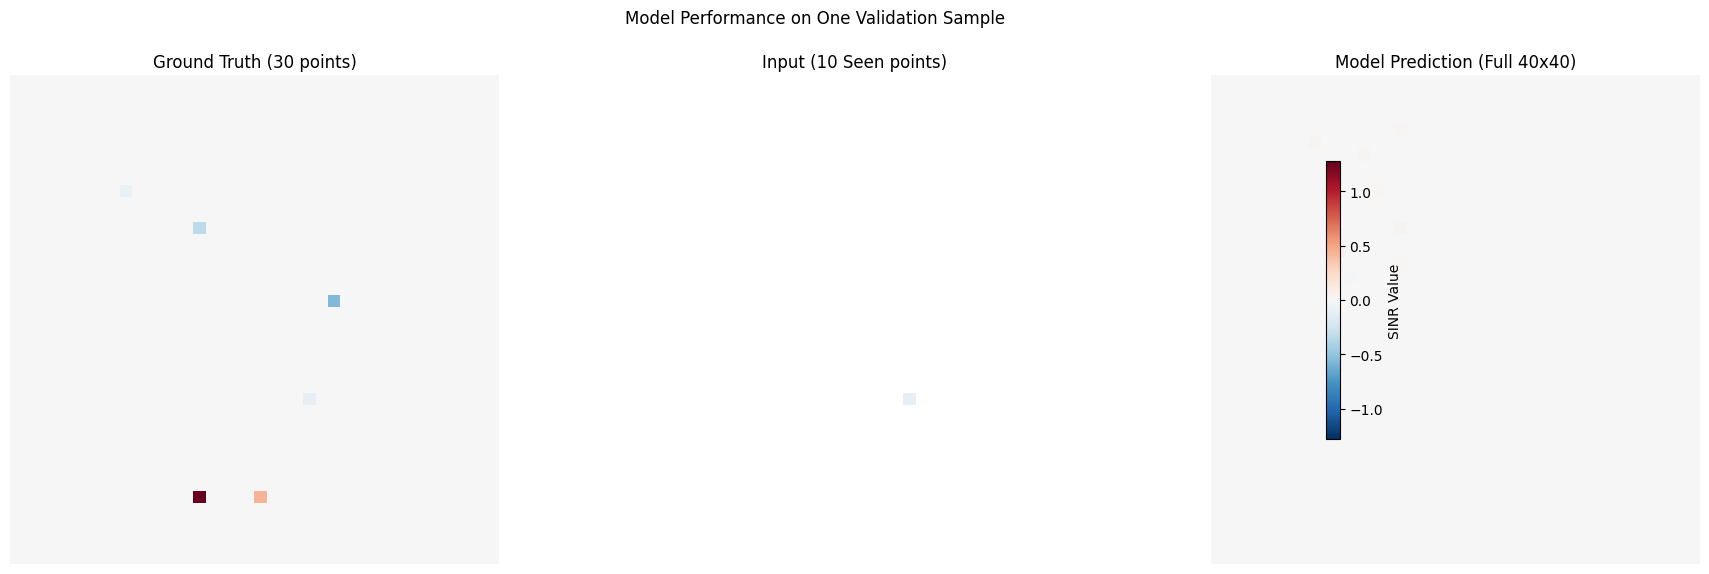

In [ ]:
# ===============================================================
# 6️⃣ Plotting Results (Option 1: Polished 1x3)
# ===============================================================
import matplotlib.pyplot as plt
import numpy as np
print("\n--- Generating plot of the results (Polished 1x3) ---")

# --- Assumes you've already run this part ---
# Get the maps as numpy arrays, squeezing batch/channel dims
gt_map = x_sample_gt.cpu().numpy().squeeze()
input_map = x_input_sample.cpu().numpy().squeeze()
pred_map = mu_pred.cpu().numpy().squeeze()
# --- End of assumed code ---

# NEW: Find a symmetric min/max for the colorbar
# This is better for diverging data (pos/neg SINR)
# Find the largest absolute value across both maps
v_abs = max(np.abs(gt_map).max(), np.abs(pred_map).max())
vmin = -v_abs
vmax = v_abs

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
fig.patch.set_facecolor('white') # Set background to white

# 1. Ground Truth
im1 = ax1.imshow(gt_map, cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax1.set_title(f"Ground Truth ({full_sensor_mask.sum().item():.0f} points)")
ax1.set_axis_off()

# 2. Input
# We replace 0s with NaNs so they plot as blank
input_map_with_nans = input_map.copy()
input_map_with_nans[input_map_with_nans == 0] = np.nan
im2 = ax2.imshow(input_map_with_nans, cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax2.set_title(f"Input ({seen_sensor_mask.sum().item():.0f} Seen points)")
ax2.set_axis_off()

# 3. Prediction
im3 = ax3.imshow(pred_map, cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax3.set_title("Model Prediction (Full 40x40)")
ax3.set_axis_off()

# Add a colorbar
# We use im3 as the source for the colorbar
fig.colorbar(im3, ax=[ax1, ax2, ax3], shrink=0.6, label="SINR Value")

plt.suptitle("Model Performance on One Validation Sample")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
""" plt.savefig("model_prediction_map_option1.png")
print("Plot saved to model_prediction_map_option1.png") """


--- Generating scatter plot for performance comparison ---


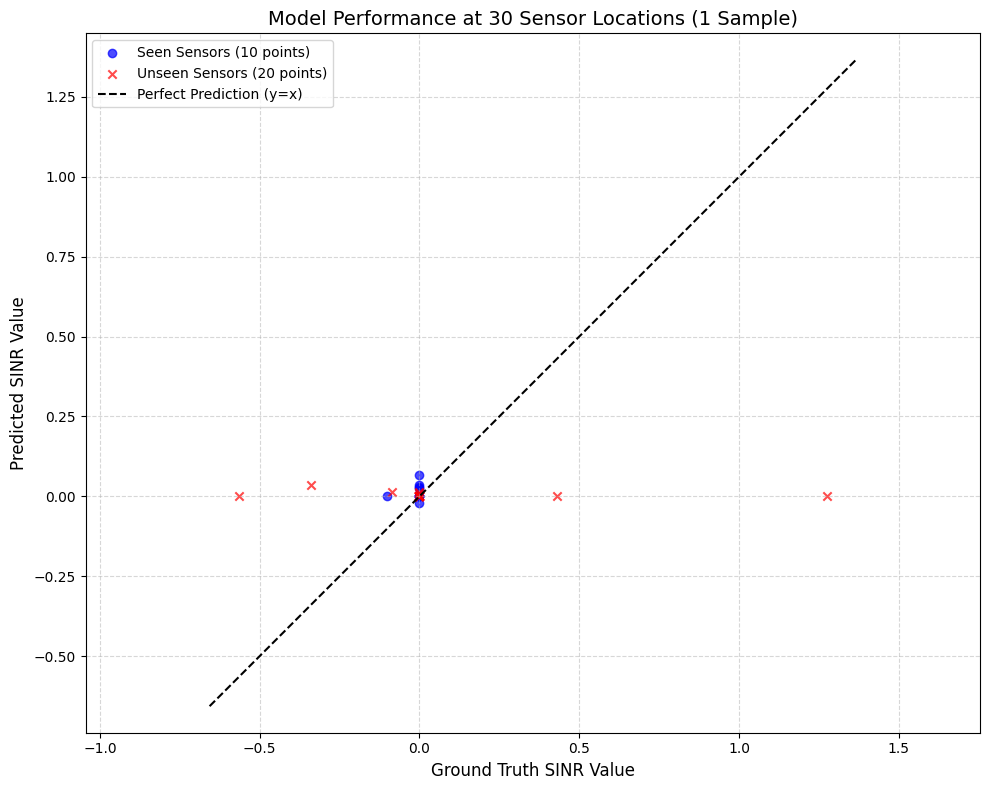

In [13]:
# ===============================================================
# 7️⃣ Scatter Plot for Direct Performance Comparison
# ===============================================================
print("\n--- Generating scatter plot for performance comparison ---")
try:
    # We already have these from Section 5:
    # seen_gt, seen_pred (for 11 seen sensors)
    # unseen_gt, unseen_pred (for 19 unseen sensors)
    
    # Detach from device and convert to numpy
    seen_gt_np = seen_gt.cpu().numpy()
    seen_pred_np = seen_pred.cpu().numpy()
    unseen_gt_np = unseen_gt.cpu().numpy()
    unseen_pred_np = unseen_pred.cpu().numpy()

    # Create a new figure
    plt.figure(figsize=(10, 8))
    
    # Plot Seen sensors
    plt.scatter(seen_gt_np, seen_pred_np, color='blue', alpha=0.7, label=f'Seen Sensors ({len(seen_gt_np)} points)')
    
    # Plot Unseen sensors
    plt.scatter(unseen_gt_np, unseen_pred_np, color='red', marker='x', alpha=0.7, label=f'Unseen Sensors ({len(unseen_gt_np)} points)')
    
    # Add a y=x line (perfect prediction line)
    all_gt = np.concatenate((seen_gt_np, unseen_gt_np))
    all_pred = np.concatenate((seen_pred_np, unseen_pred_np))
    min_val = min(all_gt.min(), all_pred.min())
    max_val = max(all_gt.max(), all_pred.max())
    padding = (max_val - min_val) * 0.05 # Add 5% padding
    
    plt.plot([min_val - padding, max_val + padding], [min_val - padding, max_val + padding], 'k--', label='Perfect Prediction (y=x)')
    
    plt.xlabel("Ground Truth SINR Value", fontsize=12)
    plt.ylabel("Predicted SINR Value", fontsize=12)
    plt.title("Model Performance at 30 Sensor Locations (1 Sample)", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axis('equal') # Ensure x and y axes have the same scale
    plt.tight_layout()


except ImportError:
    print("\n[WARNING] Matplotlib not found. Skipping scatter plot generation.")
except Exception as e:
    print(f"\n[WARNING] Could not generate scatter plot. Error: {e}")